# Prototype-Based Recurrent Drift Detection

This notebook implements a prototype-based approach for detecting concept drift in data streams, including recurrent drifts. The method:

1. Divides the stream into windows
2. Generates prototype descriptions for each window
3. Compares all windows using a distance matrix
4. Clusters windows to identify concepts and detect drifts (including recurrent ones)

The distance-based comparison allows detecting recurrent drifts since distances are based on actual similarity rather than temporal proximity.

## 1. Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from river import forest
from src.recurrence.full_window_storage import FullWindowStorage
from src.recurrence.methods import (
    cluster_windows,
    get_drift_from_clusters,
    median_mask,
    median_mask_2d,
    clustered_labels_accuracy,
    threshold_test,
    plot_threshold_analysis_results,
    create_prototypes_for_stream,
    prepare_dataset_from_generator,
    visualize_distance_matrix
)
from src.recurrence.visualisation import (
    plot_prototype_comparison,
    plot_cluster_timeline,
    plot_distance_to_all_windows,
    plot_window_detail
)

from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score

%matplotlib inline

## 2. Prepare Dataset

In [2]:
# Create the data that other methods are using for comparison to insert into stream for comparability

# Configuration
size_of_box = 1000

# Generate dataset using your dataset generator
from src.datasets import get_dataset
generator = get_dataset("rbf_drift")
X_reszta, y_reszta = generator.generate(size_of_box, size_of_box)

In [3]:
# Configuration
size_of_box = 10000

# Generate dataset using your dataset generator
from src.datasets import get_dataset
generator = get_dataset("rbf_drift")
X, y = generator.generate(size_of_box, size_of_box)

print(f"Dataset shape: X={X.shape}, y={y.shape}")
print(f"Total samples: {len(X)}")

Dataset shape: X=(20000, 4), y=(20000,)
Total samples: 20000


In [4]:
# Replace the 10th window with data other methods are using
X.iloc[10000:11000] = X_reszta.iloc[1000:2000].values
y.iloc[10000:11000] = y_reszta.iloc[1000:2000].values

In [18]:
X.drop(columns=['X6','X7','X8','X9','X10','X11',], inplace=True)

In [5]:
# Multiply the data 10 times if necessary

X_new = pd.DataFrame(
    np.vstack([
        np.tile(X.iloc[:1000].to_numpy(), (10, 1)),
        np.tile(X.iloc[1000:].to_numpy(), (10, 1)),
    ]),
    columns=X.columns
)

y_new = pd.Series(
    np.concatenate([
        np.tile(y.iloc[:1000].to_numpy(), 10),
        np.tile(y.iloc[1000:].to_numpy(), 10),
    ])
)

X = X_new
y = y_new


In [3]:
# Generate dataset using your dataset generator
from src.datasets import get_dataset
generator = get_dataset("random_tree_multi_window")
X, y = generator.generate(num_windows=30, window_length=1000,
                 drift_positions=[10_000, 20_000], drift_duration=1,)

print(f"Dataset shape: X={X.shape}, y={y.shape}")
print(f"Total samples: {len(X)}")

Dataset shape: X=(30000, 6), y=(30000,)
Total samples: 30000


In [4]:
# Prepare dataset in windowed format
window_size = 1000
dataset = prepare_dataset_from_generator(X, y, window_size=window_size)
print(f"Created {len(dataset)} windows")
print(f"Each window has {len(dataset[0][0])} samples")

Created 30 windows
Each window has 1000 samples


## 3. Run Prototype Creation and Window Storage

In [5]:
# Setup model and storage
model = forest.ARFClassifier(seed=42)
storage = FullWindowStorage()

# Create prototypes for all windows
create_prototypes_for_stream(model, storage, dataset, verbose=True)

0/30
Anomaly detected. Window: 9 class: 0
10/30
Anomaly detected. Window: 16 class: 1
Anomaly detected. Window: 17 class: 1
20/30
Anomaly detected. Window: 23 class: 0
Anomaly detected. Window: 26 class: 0
Anomaly detected. Window: 28 class: 0

Stored 30 windows


## 4. Compute Distance Matrix

In [7]:
# Compute distance matrix between all windows
# Available measures: 'centroid_displacement', 'prototype_reassignment_impact', 
#                     'minimal_distance', 'mutual_information', 'rand_index', etc.
measure = 'centroid_displacement' 

matrix = storage.compute_distance_matrix(measure=measure, verbose=True)
print(f"Matrix shape: {matrix.shape}")

Computing 30x30 distance matrix using centroid_displacement...
  Progress: 0/30
  Progress: 10/30
  Progress: 20/30
Complete!
Matrix shape: (30, 30)


## 5. Visualize Distance Matrix

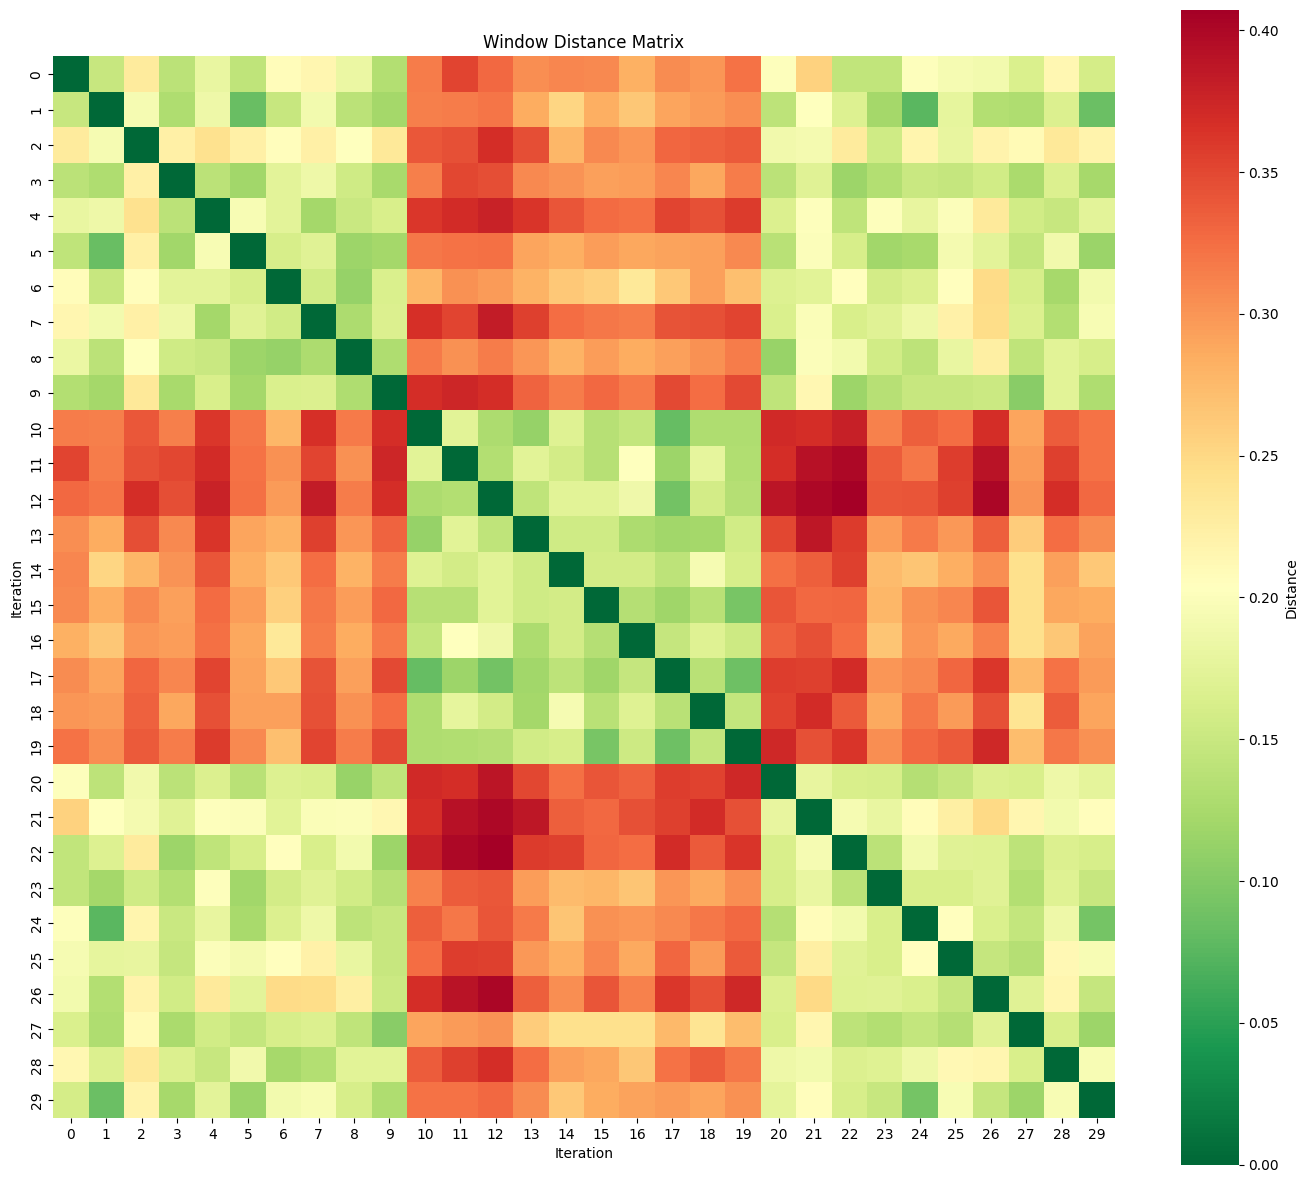

In [8]:
# Visualize the raw distance matrix
visualize_distance_matrix(matrix, title=f"Window Distance Matrix")

## 6. Cluster Windows into Concepts

In [9]:
# Cluster windows to identify concepts
# median_mask_width: Apply median filter for noise reduction (use odd numbers, 1=no filtering)
# fix_outliers: Fill gaps between same cluster labels

labels = cluster_windows(matrix, fix_outliers=True, median_mask_width=1)
print("Cluster labels:", labels)
print("\nUnique clusters and their counts:")
unique, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique, counts):
    label_str = "Outlier" if label == -1 else f"Concept {label}"
    print(f"  {label_str}: {count} windows")

Cluster labels: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]

Unique clusters and their counts:
  Concept 0: 20 windows
  Concept 1: 10 windows


In [10]:
# Detect drift locations from cluster transitions
drift_locations = get_drift_from_clusters(labels)
print(f"Detected {len(drift_locations)} drift points:")
print(drift_locations)

Detected 2 drift points:
[10, 20]


## 7. Visualize Cluster Timeline

In [11]:
# Plot interactive cluster timeline showing concept changes over time
plot_cluster_timeline(labels, drift_locations=drift_locations, 
                     title="Concept Timeline with Detected Drifts")

## 8. Distance Matrix with Drift Markers

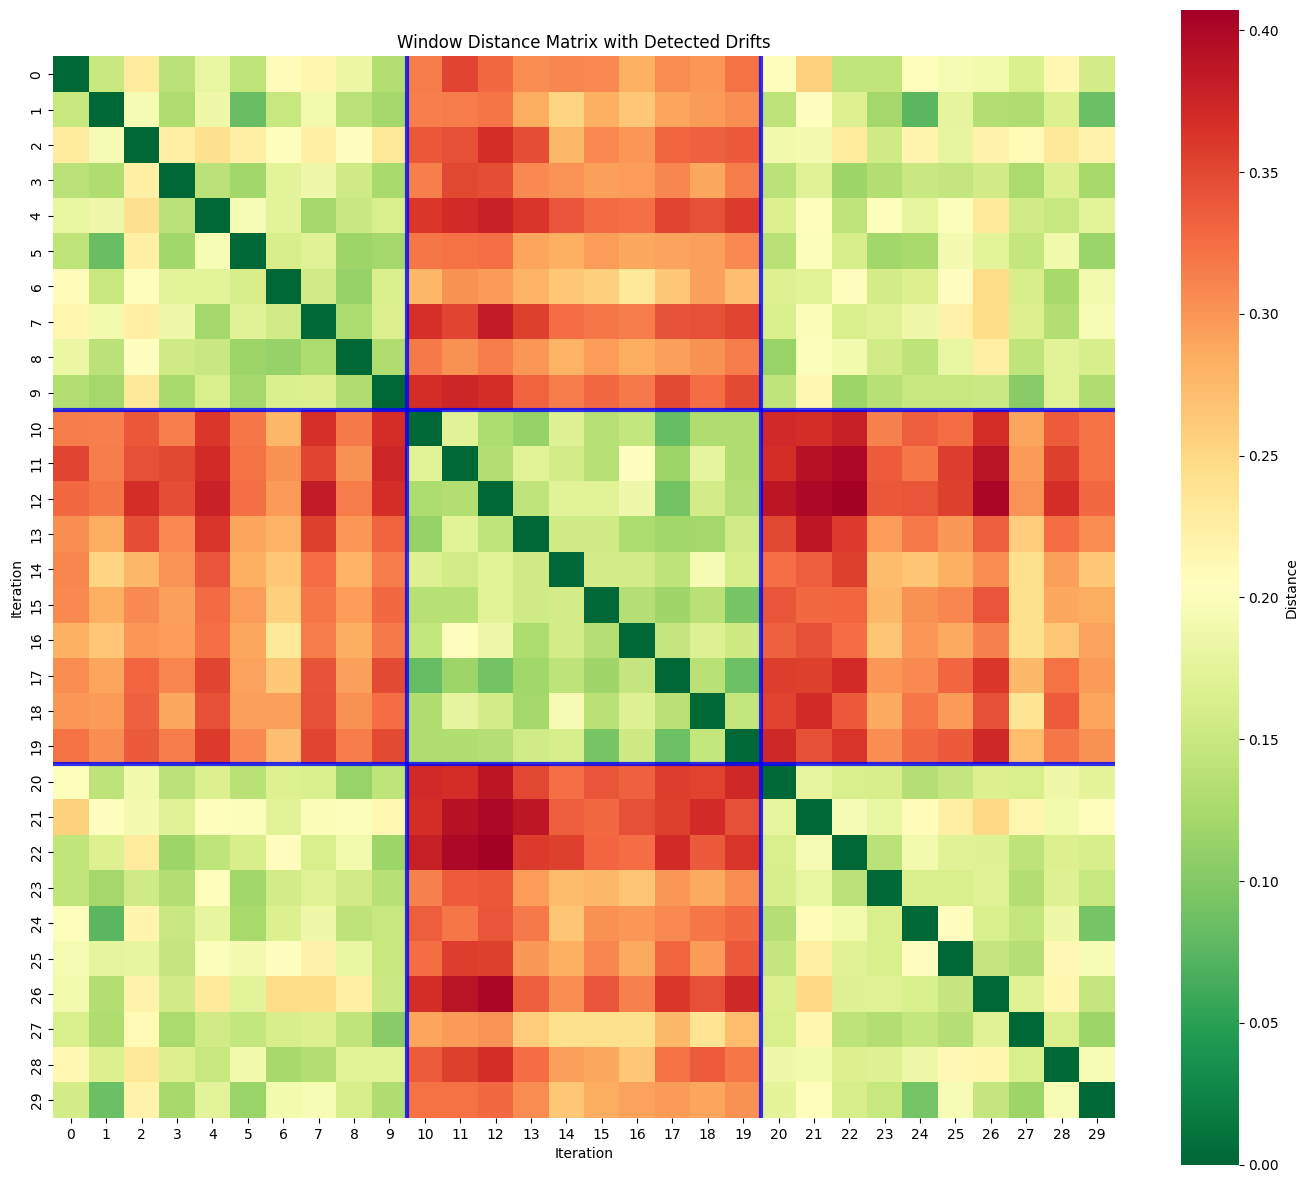

In [12]:
# Visualize distance matrix with detected drift locations marked
visualize_distance_matrix(matrix, drift_positions=drift_locations,
                         title=f"Window Distance Matrix with Detected Drifts")

## 10. Local Analysis - Distance from Specific Window

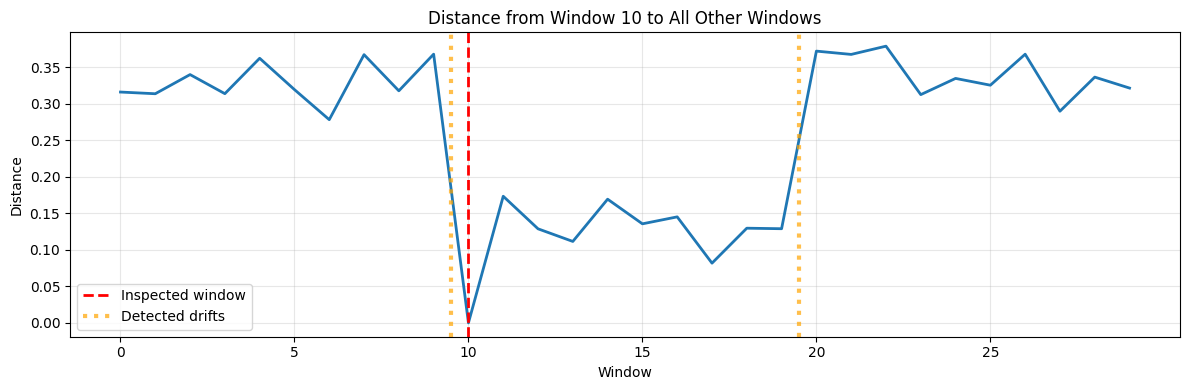

In [13]:
# Select a window to analyze
selected_window = 10

# Plot distance from selected window to all others
plot_distance_to_all_windows(storage, selected_window, 
                            drift_locations=drift_locations,
                            measure=measure, 
                            k_median=1)  # Increase for smoothing

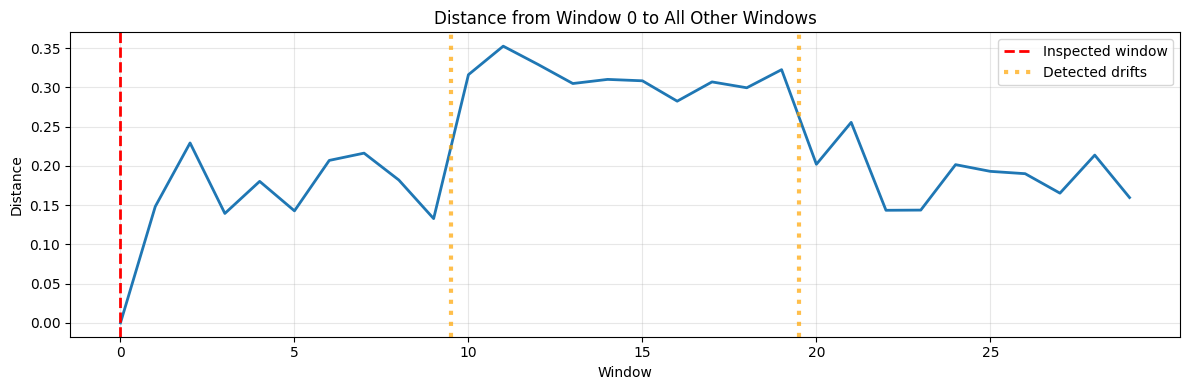

In [14]:
# Select a window to analyze
selected_window = 0

# Plot distance from selected window to all others
plot_distance_to_all_windows(storage, selected_window, 
                            drift_locations=drift_locations,
                            measure=measure, 
                            k_median=1)  # Increase for smoothing

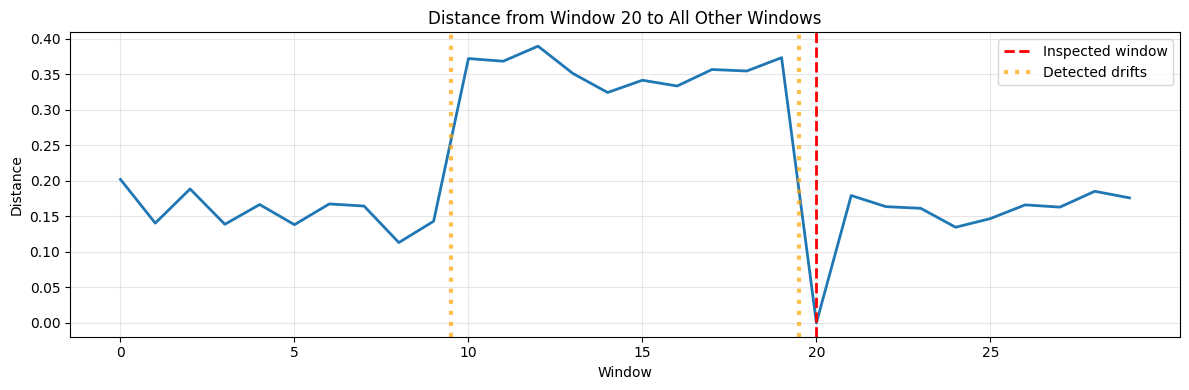

In [18]:
# Select a window to analyze
selected_window = 20

# Plot distance from selected window to all others
plot_distance_to_all_windows(storage, selected_window, 
                            drift_locations=drift_locations,
                            measure=measure, 
                            k_median=1)  # Increase for smoothing

## 11. Window Detail Analysis

In [15]:
# Detailed analysis of a specific window's prototypes
plot_window_detail(storage, selected_window)


Window 0 - Detailed Analysis

Total samples: 1000
Total prototypes: 17
Classes: [0, 1]


------------------------------------------------------------
Class 0
------------------------------------------------------------
Number of prototypes: 5
196 samples have their closest prototype from class 0

  • Prototype 1: Closest to 50 samples (Class 0: 43, Class 1: 7)
  • Prototype 2: Closest to 44 samples (Class 0: 35, Class 1: 9)
  • Prototype 3: Closest to 20 samples (Class 0: 6, Class 1: 14)
  • Prototype 4: Closest to 17 samples (Class 0: 16, Class 1: 1)
  • Prototype 5: Closest to 65 samples (Class 0: 27, Class 1: 38)

  Feature Statistics Across Prototypes:
Feature     Mean      Std      Min      Max
     x0 0.370167 0.201119 0.000000 0.610988
     x1 0.311906 0.141332 0.204842 0.584735
     x2 0.532169 0.167093 0.223413 0.706048
     x3 0.510855 0.169876 0.263819 0.782201
     x4 0.423764 0.223788 0.129279 0.750338
     x5 0.528149 0.108003 0.375660 0.647925

-------------------------

## 12. Compare Prototypes Across Windows

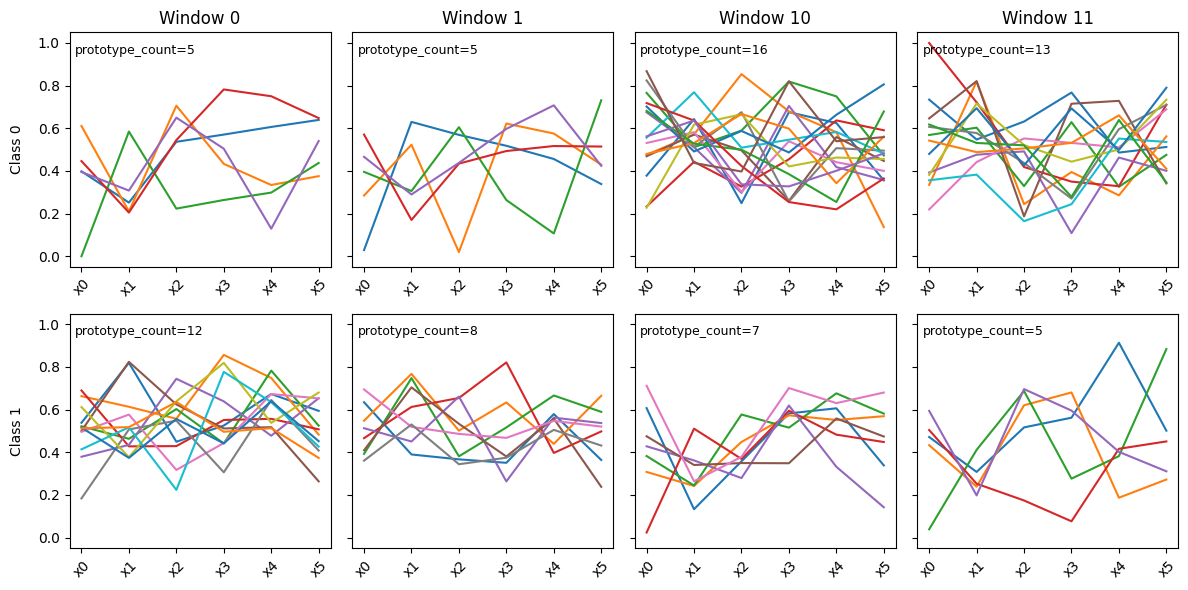

In [16]:
# Compare prototypes from different windows/concepts
# Select windows that represent different concepts or before/after drifts

windows_to_compare = [0, 1, 10, 11]

plot_prototype_comparison(storage, windows_to_compare)

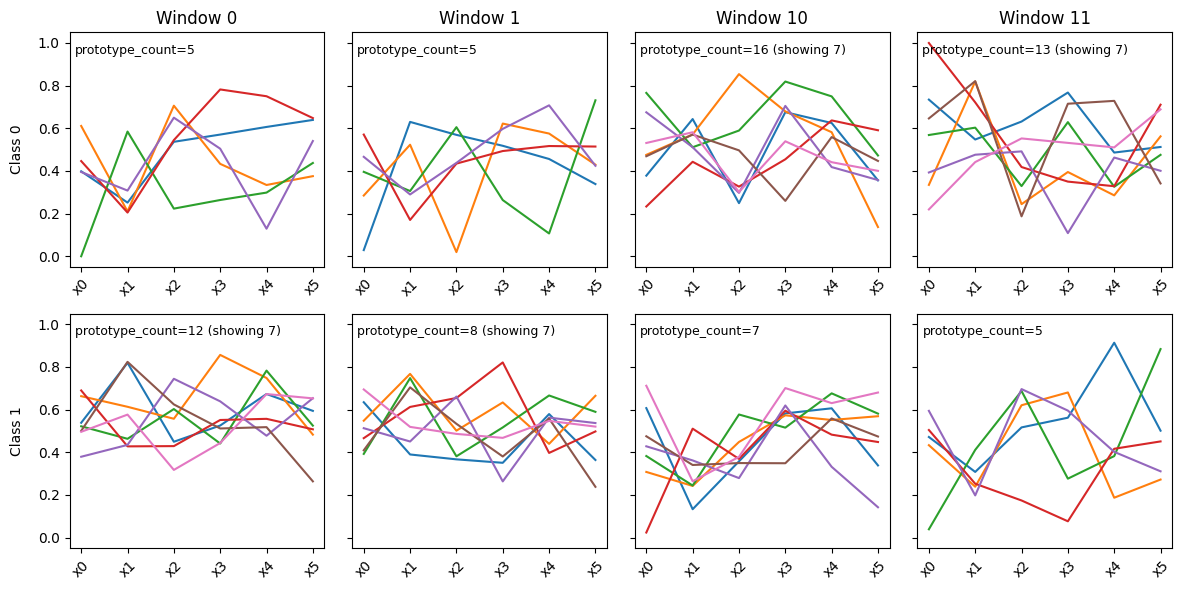

In [17]:
# Compare prototypes from different windows/concepts
# Select windows that represent different concepts or before/after drifts

windows_to_compare = [0, 1, 10, 11]

plot_prototype_comparison(storage, windows_to_compare, max_prototypes=7)

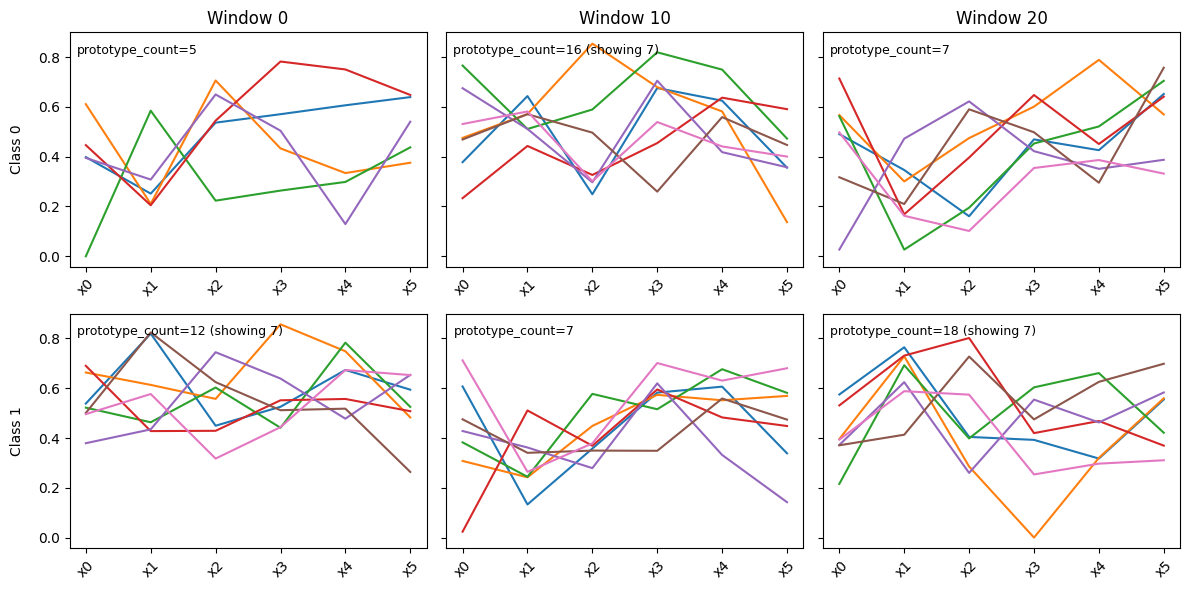

In [19]:
# Compare prototypes from different windows/concepts
# Select windows that represent different concepts or before/after drifts

windows_to_compare = [0, 10, 20]

plot_prototype_comparison(storage, windows_to_compare, max_prototypes=7)